In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

## Importing in 2014 Flares List

In [3]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [4]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [5]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Vetted Flares List

In [6]:
new_flares=pd.read_csv('/Users/lupitatovar/flares/notebooks/flare_diagnostics/flare_diagnostics.csv',
            delim_whitespace=True,names=["Flare_Number","Type","Notes"])

In [7]:
flag = pd.to_numeric(new_flares["Type"].values, errors='coerce') #nan = classical , 2= adjust start/stop , 3= remove

In [8]:
# Separating the new set of flares and printing new ammounts of flares

still_classical = len(np.where(np.isnan(flag))[0])
print ("The number of remaining classical flares : " + str(still_classical)) 

toss = len([i for i in flag if i == 3.]) 
print ("The number flares tossed out : " + str(toss)) 

edit = len([i for i in flag if i == 2.]) 
print ("The number of flares who need edited times : " + str(edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
edit_times = new_flares[new_flares["Type"].values == '2']
toss_flares = new_flares[new_flares["Type"].values == '3']
still_classic_flares = new_flares[pd.isnull(new_flares["Type"].values)]

#includes falres that need start/stop times edited
keep_flares = edit_times.combine_first(still_classic_flares)

The number of remaining classical flares : 476
The number flares tossed out : 341
The number of flares who need edited times : 83


In [9]:
#adding index column to Jim's original timed_calssical flares list
timed_classical['Index'] = np.arange(len(timed_classical))
#timed_classical

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
#cross matching the two lists to get new table that has all the flare info!

cross_match = pd.merge(left=timed_classical, right=keep_flares, left_on='Index', right_on='Flare_Number')
cross_match.shape
#cross_match


(558, 20)

In [11]:
toss = pd.merge(left=timed_classical, right=toss_flares, left_on='Index', right_on='Flare_Number')
toss.shape
#toss

(341, 20)

### Importing in GJ1243 light curve (DR-25)

In [14]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


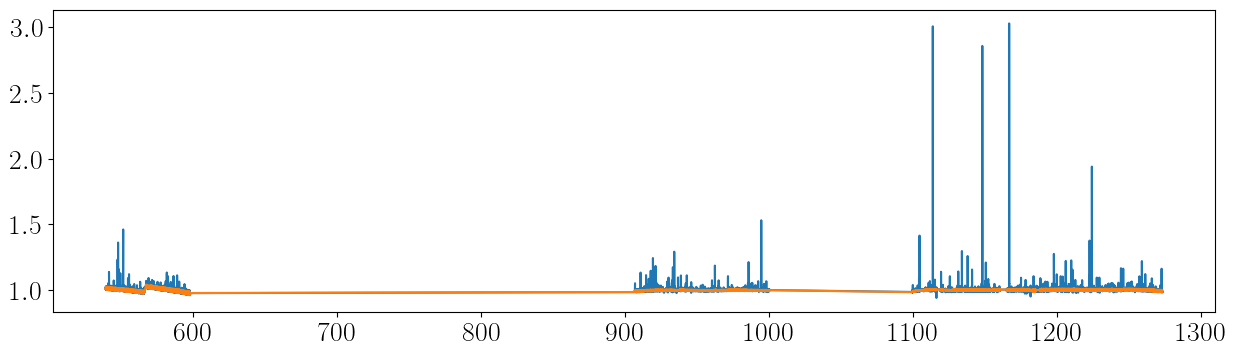

In [15]:
#Reading in the 11 mo gp files
from glob import glob

gp_files = glob('*11mo_*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()


In [16]:
#dropping the nans in the table
df = df.dropna()
df = df.reset_index(drop=True)
print(len(df))

453111


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

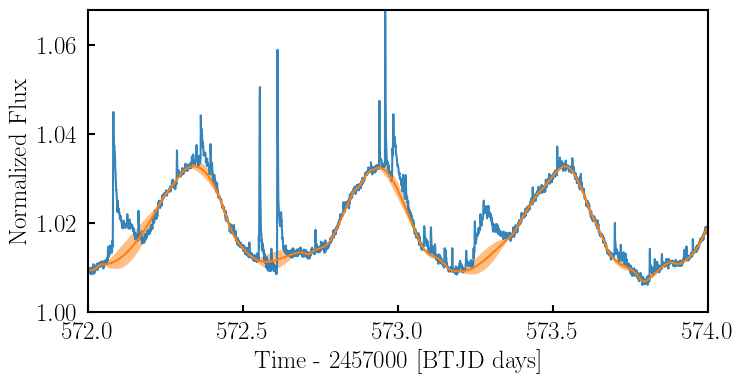

In [17]:

#rcParams["savefig.dpi"] = 300
#rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
#rcParams["figure.figsize"] = [8, 4]
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
#rcParams["text.usetex"] = True

plt.figure(figsize=[8,4])

color = "#ff7f0e"

plt.rcParams['axes.linewidth']=1.5
#plt.rcParams['xtick.major.width'] = 1.5
#plt.rcParams['ytick.major.width'] = 1.5
#plt.rc('xtick.major', size=6, pad=5)
plt.tick_params(direction='in',width=1.5,length=5,pad=7)

plt.xticks(np.arange(572,574.5, step=0.5))


plt.plot(df['time'], df['detrended_flux'],alpha=0.9)
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color=color, alpha=0.5,
                 edgecolor="none",label='gp')

plt.xlim(572,574)
#plt.xlim(914,916)
plt.ylim(1,1.068)
plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

#plt.savefig('/Users/lupitatovar/flares/figures/gp_overlay.png',bbox_inches='tight')

#plt.show()

In [18]:
detrended = df['detrended_flux'].values - df['mean'].values
#print(detrended)

In [19]:
#timed_classical
classic_start=timed_classical.loc[:,'t_start'].values
classic_stop=timed_classical.loc[:,'t_stop'].values
classic_dur = timed_classical.loc[:,'Flare_Duration'].values
#print(classic_start)

In [20]:
#timed_classical

## Putting everything into a loop to stack all flares

Variables being calculated for the flare model: center time, scale height, scale duration

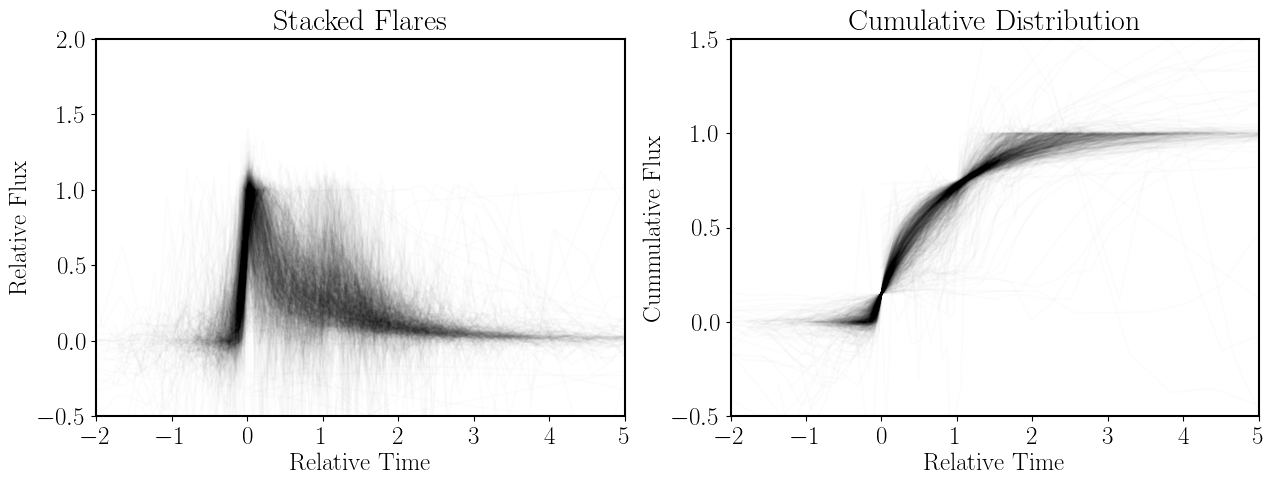

In [22]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

t_center = np.array([])          # time at 50% cummulative flux of each flare
scale_height = np.array([])  # mean flux of the entire flare 
scale_dur = np.array([])     # (t_75 - t_25)


for i in range(0,len(timed_classical)):

    #Mask of the times (t_start and t_stop) between each flare 
    temp = np.where((df['time'] < timed_classical['t_stop'].values[i]) & 
                    (df['time'] > timed_classical['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrended = np.cumsum((detrended[temp])/np.sum(detrended[temp]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    xinterp = np.interp(yvals, cd_detrended, df['time'][temp])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = xinterp[0]
    t2 = xinterp[1]#cd_flux_max / 2.0
    t3 = xinterp[2]
    
    t_center = np.append(t_center,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_mean = np.cumsum(detrended[temp])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[temp])), np.sort(detrended[temp]))
    scale_height = np.append(scale_height,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    scale_dur = np.append(scale_dur,diff_dur)
    
    
    ######## PLOTTING ################

    cd_x = (df['time'][temp] - t_center[i])/(scale_dur[i])
    cd_y = ((detrended[temp])/(scale_height[i]))

    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(cd_x,cd_y,color='k',alpha=0.01)

    #axs[1].plot((xinterp[2]-xinterp)/scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    #axs[1].plot((df['time'][temp])/scale_dur[i],cd_detrended,color='k',alpha=0.2)
    axs[1].plot(cd_x,np.cumsum(cd_y)/np.sum(cd_y),color='k',alpha=0.01)
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-2,5)
    axs[0].set_ylim(-0.5,2) 
    
    axs[1].set_xlim(-2,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')

    
    #plt.xlim(-2,5)
    #plt.ylim(-0.5,2)
    # cumulative distribution plot of the flares
    
    #plt.plot((xinterp - xinterp[1])/scale_dur[i],yvals,'x',color='orange')
    #plt.scatter(df['time'][i]- xinterp[2],cd_detrended[i])
    #plt.plot((df['time'][temp]- xinterp[1])/scale_dur[i],cd_detrended)
    #plt.xlabel("Time")
    #plt.ylabel("Flux")


## Stacked flares with newly vetted flare list

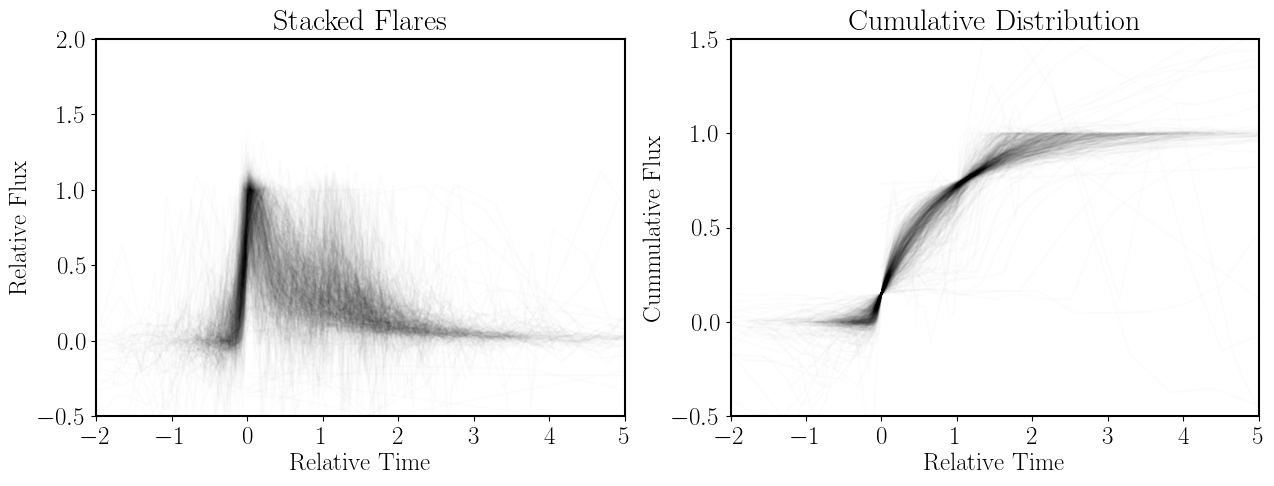

In [23]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

new_t_center = np.array([])          # time at 50% cummulative flux of each flare
new_scale_height = np.array([])  # mean flux of the entire flare 
new_scale_dur = np.array([])     # (t_75 - t_25)

#arrays that get saved into .csv
new_x_all=np.array([])
new_y_all=np.array([])
new_y_err=np.array([])
new_gp_st_dev=np.array([])

for i in range(0,len(cross_match)):

    #Mask of the times (t_start and t_stop) between each flare 
    temp = np.where((df['time'] < timed_classical['t_stop'].values[i]) & 
                    (df['time'] > timed_classical['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrended = np.cumsum((detrended[temp])/np.sum(detrended[temp]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    xinterp = np.interp(yvals, cd_detrended, df['time'][temp])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = xinterp[0]
    t2 = xinterp[1]#cd_flux_max / 2.0
    t3 = xinterp[2]
    
    new_t_center = np.append(t_center,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_mean = np.cumsum(detrended[temp])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[temp])), np.sort(detrended[temp]))
    new_scale_height = np.append(scale_height,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    new_scale_dur = np.append(scale_dur,diff_dur)
    
    
    ######## PLOTTING ################

    new_x = (df['time'][temp] - new_t_center[i])/(new_scale_dur[i])
    new_y = ((detrended[temp])/(new_scale_height[i]))
    
    
    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(new_x,new_y,color='k',alpha=0.01)


    #axs[1].plot((xinterp[2]-xinterp)/new_scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    axs[1].plot(new_x,np.cumsum(new_y)/np.sum(new_y),color='k',alpha=0.01)
    
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-2,5)
    axs[0].set_ylim(-0.5,2) 
    
    axs[1].set_xlim(-2,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')

    ########### Saving Arrays ########################
    
    # time array
    new_x_all = np.append(new_x_all,new_x)
        
    #Flux Array
    new_y_all = np.append(new_y_all,new_y)
        
       
        
        #    
    #i_max = np.argmax(detrended[temp])
    #flux_max = (detrended[temp][i_max])
    #new_peaks = np.append(new_peaks,flux_max)
        
    #Flux Errors
    
    new_flux_err = df['df_flux_err'][temp].values/new_scale_height[i] #should this be divided by peak flux not scale height?
    new_y_err = np.append(new_y_err,new_flux_err)
        
    #GP Standard Deviation
    
    new_st_dev = df['std'][temp].values/new_scale_height[i]
    new_gp_st_dev = np.append(new_gp_st_dev,new_st_dev)   
    

In [24]:
print(len(new_x_all))
print(len(new_y_all))
print(len(new_x))
print(len(cross_match))
#print(558*26)
#plt.plot(new_x_all,(new_y_all))

17603
17603
26
558


### Overlaying a running median for stacked flares plot

Text(0, 0.5, 'Relative Flux')

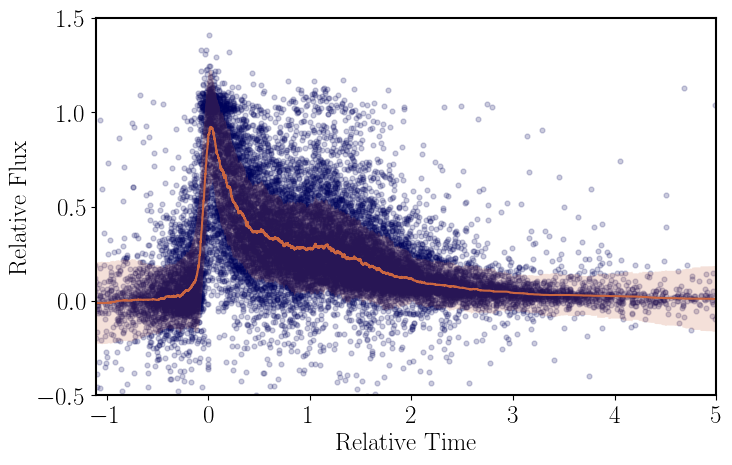

In [25]:

new_sort = np.argsort(new_x_all)
example_median=pd.Series(new_y_all[new_sort]).rolling(500, center=True).median()
example_std = pd.Series(new_y_all[new_sort]).rolling(500, center=True).std()


plt.scatter(new_x_all[new_sort],new_y_all[new_sort],color='#00035b',alpha=0.2,s=12)
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


plt.plot(new_x_all[new_sort],example_median,color='#ca6641',lw=1.5)

plt.fill_between(new_x_all[new_sort], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none")


#plt.plot(new_x_all[new_sort],example_median+example_std,color='C0',alpha=0.5)
#plt.plot(new_x_all[new_sort],example_median-example_std,color='C0',alpha=0.5)
plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

(-0.5, 1.5)

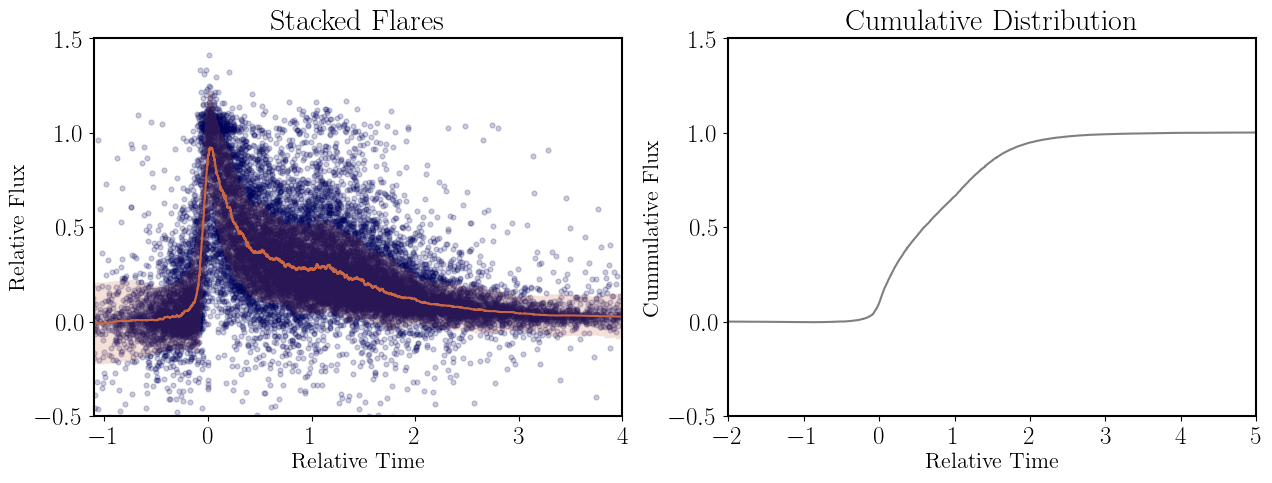

In [26]:


fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')


axs[0].scatter(new_x_all[new_sort],new_y_all[new_sort],color='#00035b',alpha=0.2,s=12)
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


axs[0].plot(new_x_all[new_sort],example_median,color='#ca6641',lw=1.5)

axs[0].fill_between(new_x_all[new_sort], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none")

axs[1].plot(new_x_all[new_sort],np.cumsum(new_y_all[new_sort])/np.sum(new_y_all[new_sort]),color='k',alpha=0.5)
    

    #Setting Titles
axs[0].set_title('Stacked Flares')
axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
axs[0].set_xlabel("Relative Time",fontsize=16)
axs[0].set_ylabel("Relative Flux",fontsize=16)    
axs[1].set_ylabel("Cummulative Flux",fontsize=16)
axs[1].set_xlabel("Relative Time",fontsize=16)

    #Axes limits
axs[0].set_xlim(-1.1,4)
axs[0].set_ylim(-0.5,1.5) 
    
axs[1].set_xlim(-2,5)
axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')


### Overplotting Jim's flare model onto this w/ amp=1,t_half=1,peak=0
https://github.com/jradavenport/appaloosa/blob/master/appaloosa/aflare.py

In [27]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

(-5.0, 15.0)

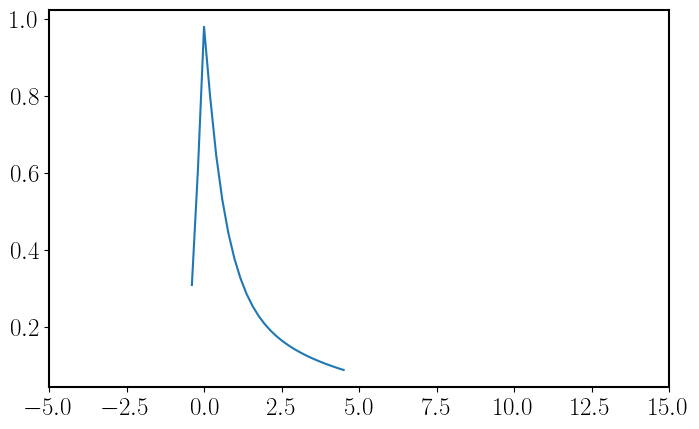

In [28]:
plt.plot(new_x,aflare1(new_x.values,0,1,1))
#plt.plot(x,jim_model,color='red')
plt.xlim(-5,15)

#### Loading in arrays from .csv so that we don't need to re-run the loop above

The arrays below contain time, flux, flux_err, and standard deviation for each flare

In [29]:
#dict_n = {'time':new_x_all,'flux': new_y_all, 'flux_err': new_y_err, 'gp_st_dev': new_gp_st_dev} 
#new_stacking_arrays = pd.DataFrame(data=dict_n) 
#new_stacking_arrays.to_csv(r'new_stacking_array_values.csv',header=True,index=True)

In [30]:
#load in the arrays (no need to re-run the for loop above)

new_stacking_arrays=pd.read_csv('new_stacking_array_values.csv')

(-5.0, 10.0)

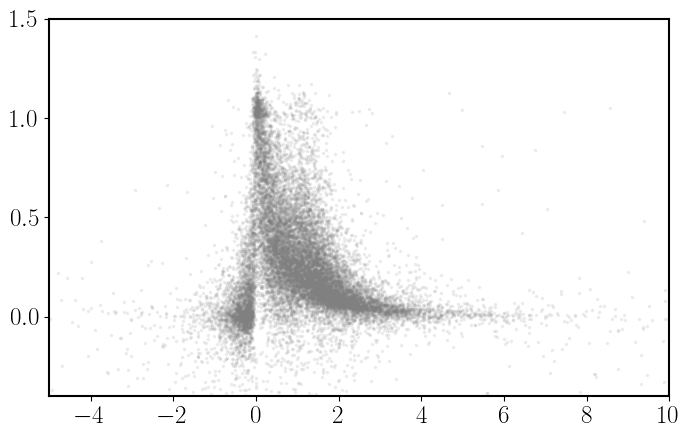

In [32]:
time = new_stacking_arrays['time'].values
flux = new_stacking_arrays['flux'].values
flux_err = new_stacking_arrays['flux_err'].values
gp_err = new_stacking_arrays['gp_st_dev'].values
both_errors = np.sqrt( (flux_err)**2 + (gp_err)**2 )

ns_all = np.argsort(time)
plt.scatter(time[ns_all],flux[ns_all],alpha=.1,s=10,marker='.',color='grey')
plt.ylim(-0.4,1.5)
plt.xlim(-5,10)

In [33]:
print((len(time[ns_all])))
print(len(df['df_flux_err'].values))

17603
453111


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'Relative Flux')

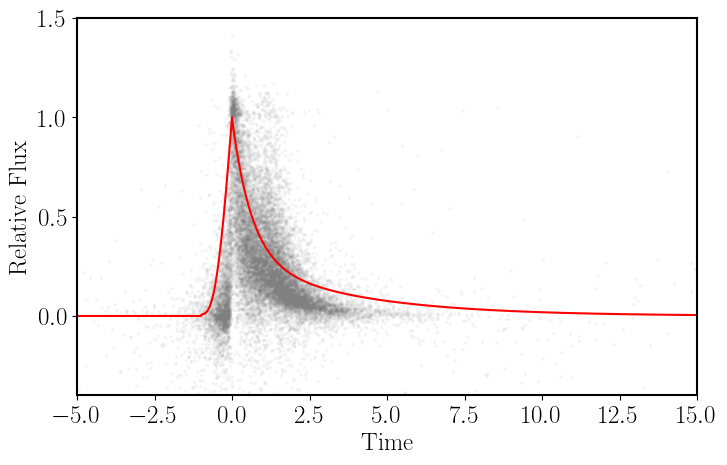

In [34]:

jim_model = aflare1(time,0,1,1)
plt.scatter(time[ns_all],flux[ns_all],alpha=.05,s=10,marker='.',color='grey')

plt.plot(time[ns_all],jim_model[ns_all],color='red')  

plt.ylim(-0.4,1.5)
plt.xlim(-5,15)
plt.xlabel('Time')
plt.ylabel('Relative Flux')

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

(-2.0, 5.0)

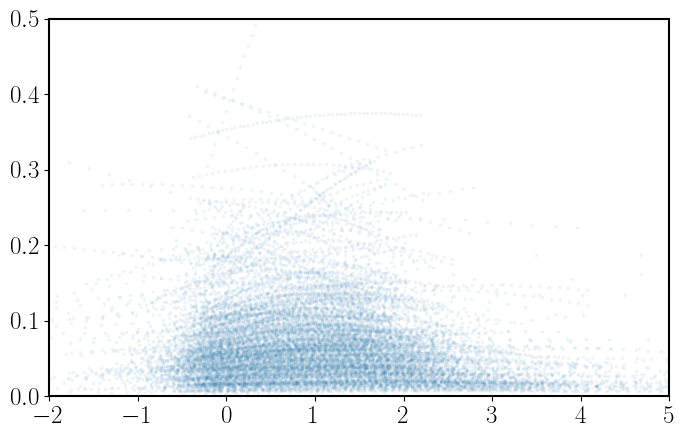

In [40]:
#plot of the gp uncertainty in our detrended data
plt.scatter(time[ns_all],gp_err[ns_all],alpha=.05,s=10,marker='.')
plt.ylim(0,0.5)
plt.xlim(-2,5)

Below is the flux error from the gp. We expect it to be a straight line centered at zero, however there is some variance between 0-0.3

(-2.0, 5.0)

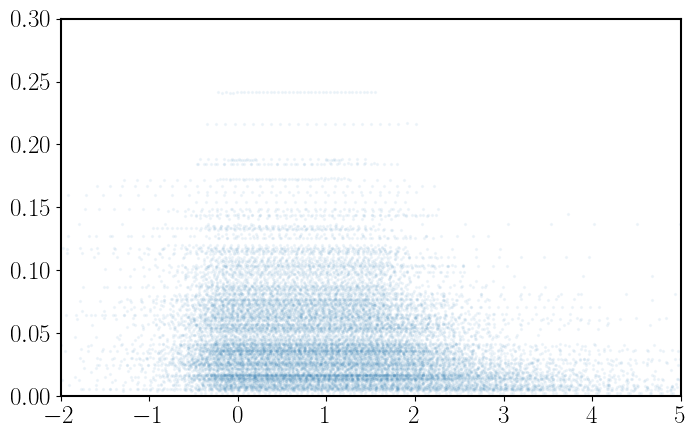

In [42]:
#plot the rolling mean and y_err

plt.scatter(time[ns_all],flux_err[ns_all],alpha=.05,s=8,marker='.')
plt.ylim(0,0.3)
plt.xlim(-2,5)

(-2.0, 5.0)

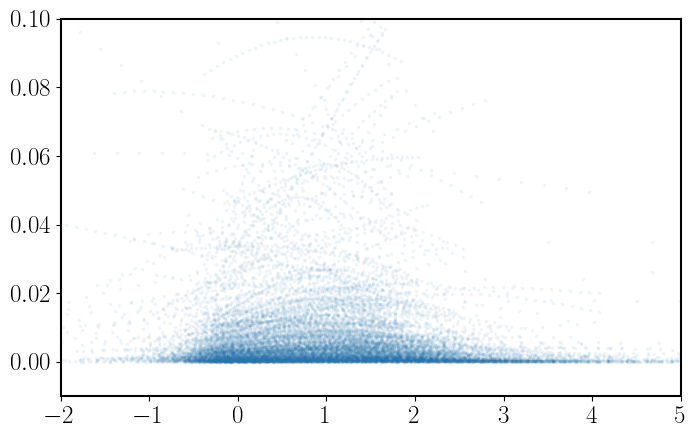

In [47]:
#plotting the variance of the st_dev (which is just the st_dev squared?)
plt.scatter(time,gp_err**2,alpha=.05,s=10,marker='.')
plt.ylim(-0.01,.1)
plt.xlim(-2,5)

Text(0, 0.5, 'Relative Flux')

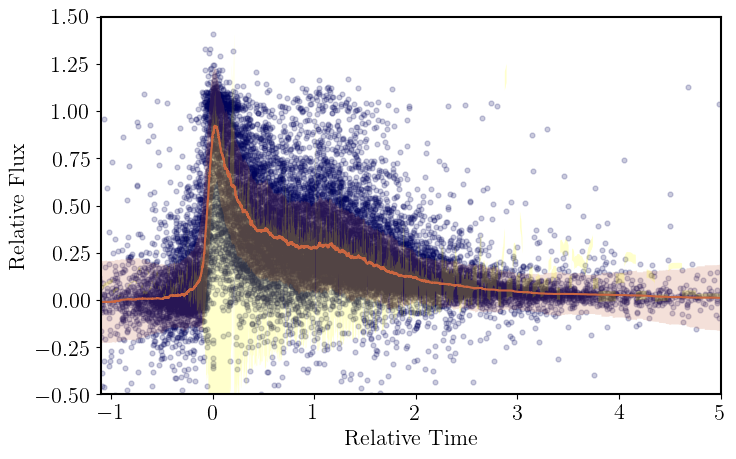

In [58]:


plt.scatter(time[ns_all],flux[ns_all],color='#00035b',alpha=0.2,s=12)
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


plt.plot(time[ns_all],example_median,color='#ca6641',lw=1.5)

#standard deviation of the median values
plt.fill_between(time[ns_all], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none")

#standard deviation of the median + the combined gp and photometric errors added in quadtrature
plt.fill_between(time[ns_all], both_errors+example_median, both_errors-example_median,color='yellow', alpha=0.2,
                 edgecolor="none")




#plt.plot(new_x_all[new_sort],example_median+example_std,color='C0',alpha=0.5)
#plt.plot(new_x_all[new_sort],example_median-example_std,color='C0',alpha=0.5)
plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

Text(0, 0.5, 'Relative Flux')

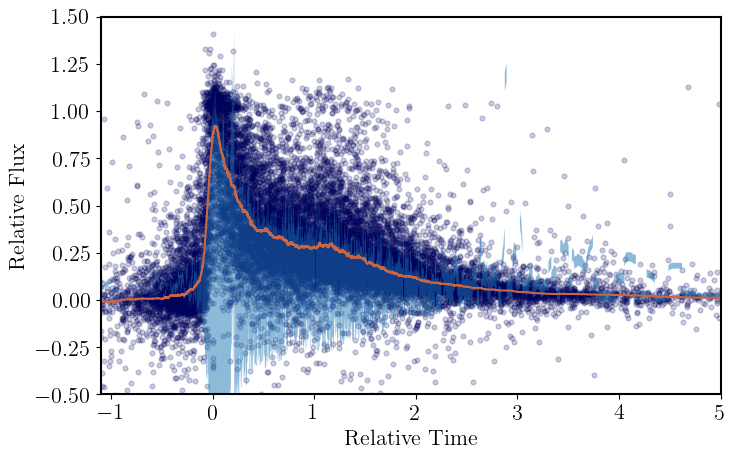

In [67]:
#example_median=pd.Series(new_y_all[new_sort]).rolling(500, center=True).median()
#example_std = pd.Series(new_y_all[new_sort]).rolling(500, center=True).std()

plt.scatter(time[ns_all],flux[ns_all],color='#00035b',alpha=0.2,s=12)
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


plt.plot(time[ns_all],example_median,color='#ca6641',lw=1.5)

#standard deviation of the median values
#plt.fill_between(time[ns_all], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 #edgecolor="none")

#standard deviation of the median + the combined gp and photometric errors added in quadtrature
plt.fill_between(time[ns_all], both_errors+example_median, both_errors-example_median,color='C0', alpha=0.5,
                 edgecolor="none")

plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

Text(0, 0.5, 'Relative Flux')

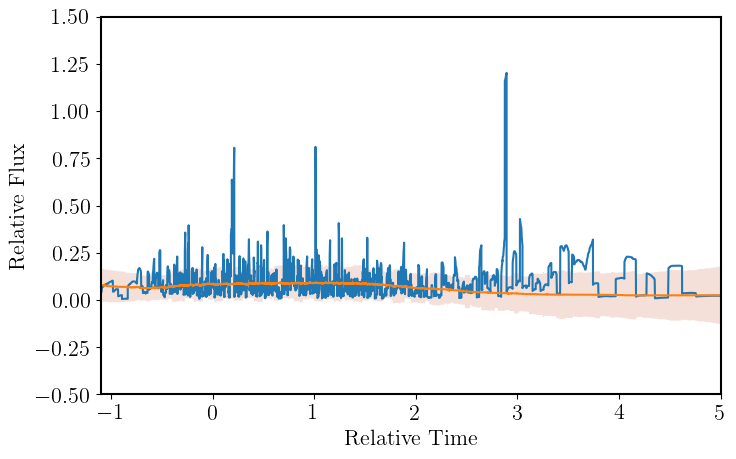

In [75]:
plt.plot(time[ns_all],both_errors)


median_of_errors = pd.Series(both_errors[ns_all]).rolling(500, center=True).median()
std_of_errors = pd.Series(both_errors[ns_all]).rolling(500, center=True).std()

plt.plot(time[ns_all],median_of_errors)
plt.fill_between(time[ns_all], median_of_errors+std_of_errors, median_of_errors-std_of_errors,color='#ca6641', alpha=0.2,
                 edgecolor="none")

plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

Text(0, 0.5, 'Relative Flux')

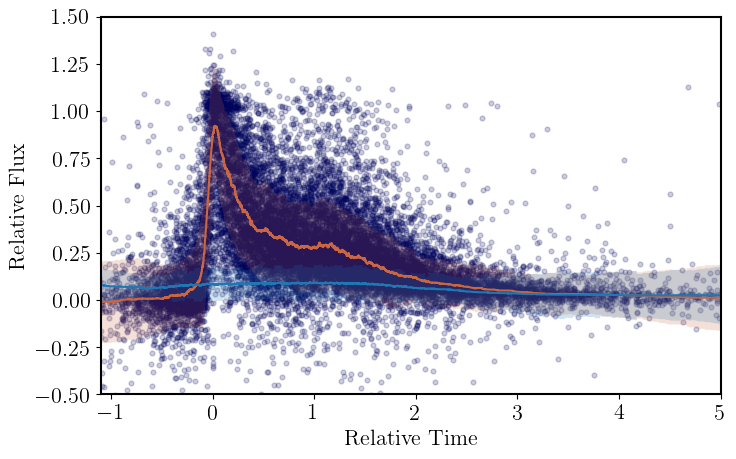

In [83]:
import matplotlib.pyplot as plt

plt.scatter(time[ns_all],flux[ns_all],color='#00035b',alpha=0.2,s=12)

#median of the data (stacked flares)
            
plt.plot(time[ns_all], example_median, color='#ca6641')

#standard deviation of data
plt.fill_between(time[ns_all], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none")

#median of the errors
plt.plot(time[ns_all],median_of_errors,color='C0')
plt.fill_between(time[ns_all], median_of_errors+std_of_errors, median_of_errors-std_of_errors,color='C0', alpha=0.2,
                 edgecolor="none")


plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

In [49]:

from scipy import special
def flare_model(t,tpeak, fwhm, ampl):
    '''
    The Continuous Flare Model evaluated for single-peak (classical) flare events.
    Use this function for fitting classical flares with most curve_fit
    tools.

    References
    --------------
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Jackman et al. (2018)

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over

    tpeak : float
        The time of the flare peak

    fwhm : float
        The Full Width at Half Maximum, timescale of the flare

    ampl : float
        The amplitude of the flare


    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time

        The convolution of a double exponential with a gaussian to give us a continuous flare model
    '''

    t_new = (t-tpeak)/fwhm


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = 2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl


### Fitting New Flare Model to GJ1243 data

Text(0, 0.5, 'Relative Flux')

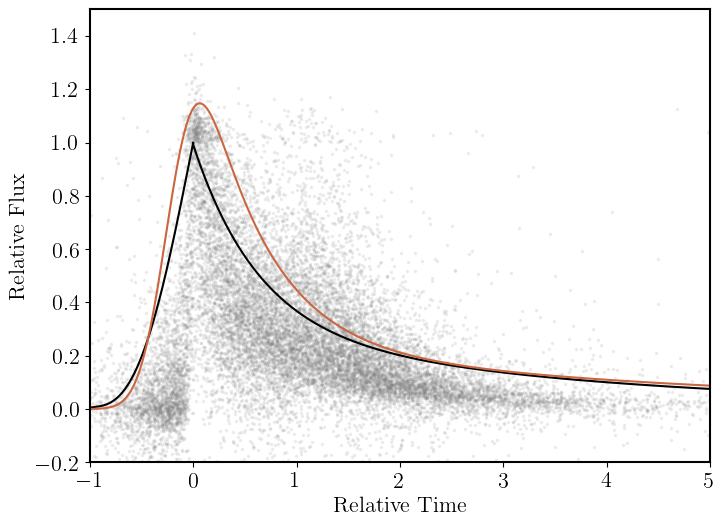

In [53]:
plt.figure(figsize=(8, 6))
font = {'size'   : 16}
plt.rc('font', **font)

plt.plot(time[ns_all],jim_model[ns_all],color='black',label='Davenport (2014) et.al')
#plt.plot(time[ns_all]-2,flare_model(time,0,1,1)[ns_all],label='New model',color='C0')
plt.plot(time[ns_all]-2,flare_model(time,0,1,1.2)[ns_all],label='New model',color='#ca6641')
#plt.plot(time[ns_all],jackman2(time,(0.91780987, 1.72326426, 0.25978216, 0.81791936, 72.63673096, 2.76862114))[ns_all],label='Jims vals',color='orange')
plt.scatter(time[ns_all],flux[ns_all],alpha=0.1,s=10,marker='.',color='grey')
#plt.xlim(-4,5)
plt.ylim(-0.2,1.5)
plt.xlim(-1,5)
#plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')

### Fitting each flare

In [ ]:
from scipy.optimize import least_squares,curve_fit, minimize

In [ ]:
#fitting using Flare model based on the Jackman model (double exponential)


#EDIT
flare1 = flare_model(time,0,1,1)[ns_all]

#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
init_vals = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]  
#init_vals = [0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682] 
best_vals, covar = curve_fit(flare1, time, flux, p0=init_vals,maxfev=10000)
print('best_vals: {}'.format(best_vals))

In [ ]:
print(np.isfinite(time))
print(time)

In [ ]:
#plt.figure(figsize=(6, 4))
plt.scatter(time,flux,alpha=.07,s=10,marker='.',label='Data')
plt.plot(time, flare_model(time,*best_vals),label='Fit',color='red')

plt.plot(time, flare_model(time, *init_vals),color='orange',label='init vals')

plt.legend(loc='best')
#plt.ylim(-0.25,1.05)
#plt.show()

In [ ]:
for i in range (0,len(cross_match)):
    